<a href="https://colab.research.google.com/github/nadaz10/NER-using-NN-and-LSTM/blob/main/Copy_of_A3P1_Named_Entity_Recognition_FFNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook for Programming in Problem 3
Welcome to the programming portion of the assignment! Each assignment throughout the semester will have a written portion and a programming portion. We will be using [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb#recent=true), so if you have never used it before, take a quick look through this introduction: [Working with Google Colab](https://docs.google.com/document/d/1LlnXoOblXwW3YX-0yG_5seTXJsb3kRdMMRYqs8Qqum4/edit?usp=sharing).

We'll also be programming in Python, which we will assume a basic familiarity with. Python has fantastic community support and we'll be using numerous packages for machine learning (ML) and natural language processing (NLP) tasks.

## Learning Objectives
In this problem, we will use [PyTorch](https://pytorch.org/) to implement feedforward neural networks (FFNNs) and long short-term memory (LSTM) for named entity recognition (NER). We will use the same dataset as in Assignment #2.

## Writing Code
Look for the keyword "TODO" and fill in your code in the empty space.
Feel free to change function signatures, but be careful that you might need to also change how they are called in other parts of the notebook.

## Use GPUs in Colab

GPUs are not strictly necessary for this assignment, but they will accerlerate your experiments and may be helpful for your final project. To enable the free GPU provided by Colab, just go to **Edit > Notebook settings** and select **GPU** as **Hardware accelerator**. To test your GPU, run the `nvidia-smi` command.

In [1]:
!nvidia-smi

Sun May  5 22:06:41 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

You should see a table summarizing the current status of the GPU, including the model, power consumption, GPU memory usage, etc. However, Colab does not guarantee which model you will get. We tested the assignment successfully on Tesla T4 but had some problems on other GPUs. **Please make sure you get a Tesla T4** by checking the output of `nvidia-smi`. We empirically observe that you are more likely to get a T4 **with your Princeton account**.

If you are still unable to get a T4. You have 3 options:
1. Reload the page until you get one.
2. Proceed with other GPUs. They should work as long as Colab does not crash when executing code.
3. Disable the GPU and use the CPU for this assignment, which is totally fine.

## Learning PyTorch

This assignment assumes basic familiarity with [PyTorch](https://pytorch.org/), which is a much needed skill for the upcoming Assignment #4, for the final project, and even beyond this course. If you aren't familiar with PyTorch, don't worry, it's a great time to start now! Here are some resources to help you get started. You may also find plenty of them online.

* We will cover PyTorch in the precept on 3/18. Watch the video on Canvas if you are not able to make it.
* [Deep Learning with PyTorch: A 60 Minute Blitz](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)
* [Learning PyTorch with Examples](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html)


## Installing PyTorch and Other Packages

Install PyTorch using pip. See [https://pytorch.org/](https://pytorch.org/) if you want to install it on your computer.

In [2]:
!pip install torch torchtext -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64

Test if our installation works:

In [3]:
import torch

# Multiply two matrices on GPU
a = torch.rand(100, 200).cuda()
b = torch.rand(200, 100).cuda()
c = torch.matmul(a, b)

print("PyTorch successfully installed!")
print("Version:", torch.__version__)

PyTorch successfully installed!
Version: 2.2.1+cu121


Also install [scikit-learn](https://scikit-learn.org/stable/). We will use it for calculating evaluation metrics such as accuracy and F1 score.

In [4]:
!pip install -U scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 37.1 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


Let's import all the packages at once:

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchtext.vocab import Vocab, vocab
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import re
from collections import Counter
from typing import List, Tuple, Dict, Optional, Any

## Feedforward Neural Network (FFNN)

### Data Loading

We will use the same dataset for named entity recognition in Assignment #2. First download the data and take a look at the first 50 lines:

In [6]:
!wget --quiet https://princeton-nlp.github.io/cos484/assignments/a2/eng.train
!wget --quiet https://princeton-nlp.github.io/cos484/assignments/a2/eng.val
!cat eng.train | head -n 50

EU NNP I-NP ORG
rejects VBZ I-VP O
German JJ I-NP MISC
call NN I-NP O
to TO I-VP O
boycott VB I-VP O
British JJ I-NP MISC
lamb NN I-NP O
. . O O

Peter NNP I-NP PER
Blackburn NNP I-NP PER

BRUSSELS NNP I-NP LOC
1996-08-22 CD I-NP O

The DT I-NP O
European NNP I-NP ORG
Commission NNP I-NP ORG
said VBD I-VP O
on IN I-PP O
Thursday NNP I-NP O
it PRP B-NP O
disagreed VBD I-VP O
with IN I-PP O
German JJ I-NP MISC
advice NN I-NP O
to TO I-PP O
consumers NNS I-NP O
to TO I-VP O
shun VB I-VP O
British JJ I-NP MISC
lamb NN I-NP O
until IN I-SBAR O
scientists NNS I-NP O
determine VBP I-VP O
whether IN I-SBAR O
mad JJ I-NP O
cow NN I-NP O
disease NN I-NP O
can MD I-VP O
be VB I-VP O
transmitted VBN I-VP O
to TO I-PP O
sheep NN I-NP O
. . O O

Germany NNP I-NP LOC
's POS B-NP O
representative NN I-NP O


Each line corresponds to a word. Different sentences are separated by an additional line break. Take "EU NNP I-NP ORG" as an example. "EU" is a word. "NNP" and "I-NP" are tags for POS tagging and chunking, which we will ignore. "ORG" is the tag for NER, which is our prediction target. There are 5 possible values for the NER tag: ORG, PER, LOC, MISC, and O.



First, we write a dataloader for loading the dataset into mini-batches used for training the model. See [torch.utils.data](https://pytorch.org/docs/stable/data.html) for how dataloaders work in PyTorch. In short, we typically need to do two things:
1. Define a [map-style dataset](https://pytorch.org/docs/stable/data.html#map-style-datasets) by subclassing [Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) and overriding 3 methods: `__init__`, `__getitem__`, and `__len__`.
1. Create a [Dataloader](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) by calling its constructor. We have to specify the dataset and a few hyperparameters such as batch size.

Most of the work has been done by us. As a simple exercise, try to understand the code and implement `__len__`.

In [7]:
# A sentence is a list of (word, tag) tuples.
# For example, [("hello", "O"), ("world", "O"), ("!", "O")]
Sentence = List[Tuple[str, str]]


def read_data_file(
    datapath: str,
) -> Tuple[List[Sentence], Dict[str, int], Dict[str, int]]:
    """
    Read and preprocess input data from the file `datapath`.
    Example:
    ```
        sentences, word_cnt, tag_cnt = read_data_file("eng.train")
    ```
    Return values:
        `sentences`: a list of sentences, including words and NER tags
        `word_cnt`: a Counter object, the number of occurrences of each word
        `tag_cnt`: a Counter object, the number of occurences of each NER tag
    """
    sentences: List[Sentence] = []
    word_cnt: Dict[str, int] = Counter()
    tag_cnt: Dict[str, int] = Counter()

    for sentence_txt in open(datapath).read().split("\n\n"):
        if "DOCSTART" in sentence_txt:
            # Ignore dummy sentences at the begining of each document.
            continue
        # Read a new sentence
        sentences.append([])
        for token in sentence_txt.split("\n"):
            w, _, _, t = token.split()
            # Replace all digits with "0" to reduce out-of-vocabulary words
            w = re.sub("\d", "0", w)
            word_cnt[w] += 1
            tag_cnt[t] += 1
            sentences[-1].append((w, t))

    return sentences, word_cnt, tag_cnt



**Let's visualize the dataset**

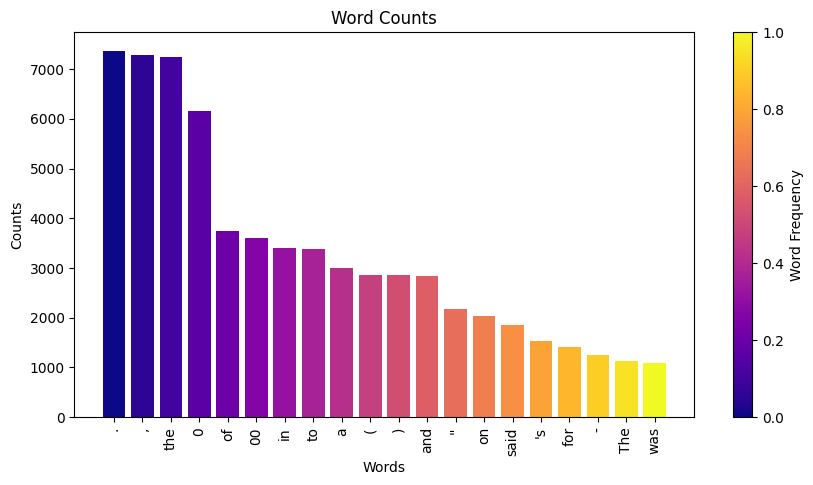

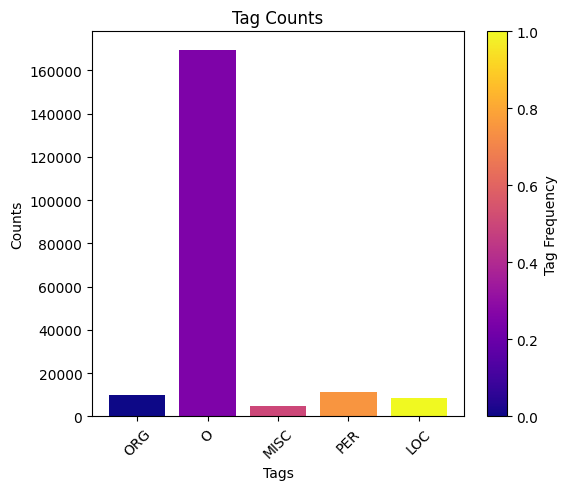

In [24]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_word_counts(word_cnt):
    # Get the 20 most common words and their counts
    words, counts = zip(*word_cnt.most_common(20))

    # Create a colormap using Plasma
    colors = plt.cm.plasma(np.linspace(0, 1, len(words)))

    # Plot word counts
    plt.figure(figsize=(10, 5))
    bars = plt.bar(words, counts, color=colors)
    plt.xlabel('Words')
    plt.ylabel('Counts')
    plt.title('Word Counts')
    plt.xticks(rotation=90)

    # Add a colorbar to indicate word frequency
    cbar = plt.colorbar(plt.cm.ScalarMappable(cmap='plasma'), ax=plt.gca())
    cbar.set_label('Word Frequency')

    plt.show()

def visualize_tag_counts(tag_cnt):
    # Get tags and their counts
    tags, counts = zip(*tag_cnt.items())

    # Create a colormap using Plasma
    colors = plt.cm.plasma(np.linspace(0, 1, len(tags)))

    # Plot tag counts
    plt.figure(figsize=(6, 5))
    bars = plt.bar(tags, counts, color=colors)
    plt.xlabel('Tags')
    plt.ylabel('Counts')
    plt.title('Tag Counts')
    plt.xticks(rotation=45)

    # Add a colorbar to indicate tag frequency
    cbar = plt.colorbar(plt.cm.ScalarMappable(cmap='plasma'), ax=plt.gca())
    cbar.set_label('Tag Frequency')

    plt.show()

# Assuming you already have the word_cnt and tag_cnt dictionaries from your read_data_file function
visualize_word_counts(word_cnt)
visualize_tag_counts(tag_cnt)





## Implement the `__len__` function below **(1 point)**

-It extracts fixed windows centered around each word in the dataset.


-It creates vocabulary objects for words and tags, where START, END, and UNKNOWN are treated as special tokens

In [8]:

class FixedWindowDataset(Dataset):
    """
    Each data example is a word, its NER tag (the target), and a fixed window centered around it (the input).
    """

    def __init__(
        self,
        datapath: str,
        window_size: int,
        words_vocab: Optional[Vocab] = None,
        tags_vocab: Optional[Vocab] = None,
    ) -> None:
        """
        Initialize the dataset by reading from datapath.
        """
        super().__init__()
        self.examples = []
        START = "<START>"
        END = "<END>"
        UNKNOWN = "<UNKNOWN>"


        #Loads from datapath:

        print("Loading data from %s" % datapath)
        sentences, word_cnt, tag_cnt = read_data_file(datapath)

        # Extract windows
        for sent in sentences:
            words = [START for _ in range(window_size)]
            tags = [None for _ in range(window_size)]
            for w, t in sent:
                words.append(w)
                tags.append(t)
            words.extend([END for _ in range(window_size)])
            tags.extend([None for _ in range(window_size)])

            for i, t in enumerate(tags[window_size:-window_size], start=window_size):
                self.examples.append(
                    {
                        "word": words[i],
                        "tag": t,
                        "context": words[i - window_size : i + window_size + 1],
                    }
                )

        print("%d examples loaded." % len(self.examples))

        # set vocabs
        if words_vocab is None:
            words_vocab = vocab(word_cnt, specials=[START, END, UNKNOWN]) # automatically create a vocabulary from words in dataset
            words_vocab.set_default_index(words_vocab[UNKNOWN])
        self.words_vocab = words_vocab
        self.unknown_idx = self.words_vocab[UNKNOWN]
        self.start_idx = self.words_vocab[START]
        self.end_idx = self.words_vocab[END]

        if tags_vocab is None:
            tags_vocab = vocab(tag_cnt, specials=[]) # automatically create tags vocabulary from tags in dataset
        self.tags_vocab = tags_vocab

    def __getitem__(self, idx: int) -> Dict[str, Any]:
        """
        Get the idx'th example in the dataset.
        Convert words and the tag to indexes.
        """
        example = self.examples[idx]
        word = example["word"]
        tag = example["tag"]
        context = example["context"]
        return {
            "word": word,
            "word_idx": self.words_vocab[word],
            "tag": tag,
            "tag_idx": self.tags_vocab[tag],
            "context": context,
            "context_idxs": torch.tensor(
                [self.words_vocab[w] for w in context]
            ),
        }

    def __len__(self) -> int:
         return len(self.examples)




In [9]:
def create_fixed_window_dataloaders(
    batch_size: int, window_size: int, shuffle: bool = True
) -> Tuple[DataLoader, DataLoader, Dict[str, Vocab]]:
    """
    Create the dataloaders for training and validaiton.
    """
    ds_train = FixedWindowDataset("eng.train", window_size)
    # Re-use the vocabulary of the training data
    ds_val = FixedWindowDataset("eng.val", window_size, words_vocab=ds_train.words_vocab, tags_vocab=ds_train.tags_vocab)
    loader_train = DataLoader(
        ds_train, batch_size, shuffle, drop_last=True, pin_memory=True
    )
    loader_val = DataLoader(ds_val, batch_size, pin_memory=True)
    return loader_train, loader_val, ds_train

to visualize a fixed window:

In [28]:
import random

# Get a random subset of examples from ds_train
num_examples_to_visualize = 2
random_examples = random.sample(ds_train.examples, num_examples_to_visualize)

# Visualize the windowed context for each example
for i, example in enumerate(random_examples, 1):
    word = example["word"]
    tag = example["tag"]
    context = example["context"]
    print(f"Example {i}:")
    print(f"Word: {word}, Tag: {tag}")
    print("Context:")
    print(context)
    print()


Example 1:
Word: past, Tag: O
Context:
['line', 'in', 'the', 'past', 'when', 'Moslem', 'refugees']

Example 2:
Word: its, Tag: O
Context:
['later', 'IVAC', 'improved', 'its', 'system', 'with', 'the']



Let's test our dataloader. Try to understand the output, as it will save your time later.

In [31]:
def check_fixed_window_dataloader() -> None:
    loader_train, _, _ = create_fixed_window_dataloaders(
        batch_size=3, window_size=2, shuffle=False
    )
    print("Iterating on the training data..")
    for i, data_batch in enumerate(loader_train):
        if i == 0:
            print(data_batch)
            print(len(data_batch["context"]))
            print(data_batch["context_idxs"].shape)
    print("Done!")


check_fixed_window_dataloader()

Loading data from eng.train
203621 examples loaded.
Loading data from eng.val
49086 examples loaded.
Iterating on the training data..
{'word': ['EU', 'rejects', 'German'], 'word_idx': tensor([3, 4, 5]), 'tag': ['ORG', 'O', 'MISC'], 'tag_idx': tensor([0, 1, 2]), 'context': [['<START>', '<START>', 'EU'], ['<START>', 'EU', 'rejects'], ['EU', 'rejects', 'German'], ['rejects', 'German', 'call'], ['German', 'call', 'to']], 'context_idxs': tensor([[0, 0, 3, 4, 5],
        [0, 3, 4, 5, 6],
        [3, 4, 5, 6, 7]])}
5
torch.Size([3, 5])
Done!


### Implement the Model **(4 points)**   

Next, let's implement feedforward neural networks following the description of Problem 1 in Assignment #3.

Models in PyTorch are subclasses of [torch.nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module). You have to override `__init__` for initializing the model and `forward` for calculating the forward pass. Checkout this [tutorial](https://pytorch.org/tutorials/beginner/nn_tutorial.html#) if you are not sure how torch.nn.Module works.

PyTorch provides a wide array of [neural network layers](https://pytorch.org/docs/stable/nn.html) as building blocks for your model. Here are some of them that may be relevant:
* [nn.Embedding](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html#torch.nn.Embedding)
* [nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear)
* [torch.sigmoid](https://pytorch.org/docs/stable/generated/torch.sigmoid.html#torch.sigmoid) or [nn.Sigmoid](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html#torch.nn.Sigmoid)

Note a difference with Problem 3 of Assignment #2 is that we do not apply softmax when calculatinng $\hat{y}^{(t)}$. Instead, we leave what softmax does to the loss function [F.cross_entropy](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.cross_entropy). For details, please see its difference with [F.nll_loss](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.nll_loss).

**Explanation of the model:**

it's a 2 layers model with a sigmoid activation function


In [11]:
class FFNN(nn.Module):
    """
    Feedforward Neural Networks for NER
    """

    def __init__(
        self, words_vocab: Vocab, tags_vocab: Vocab, window_size: int, d_emb: int, d_hidden: int
    ) -> None:
        """
        Initialize a two-layer feedforward neural network with sigmoid activation.
        Parameters:
            `words_vocab`: vocabulary of words
            `tags_vocab`: vocabulary of tags
            `window_size`: size of the context window (w in Problem 3 of Assignment #2)
            `d_emb`: dimension of word embeddings (D in Problem 3 of Assignment #2)
            `d_hidden`: dimension of the hidden layer (H in Problem 3 of Assignment #2)
        """
        super().__init__()
        self.words_vocab_size = len(words_vocab)
        self.tags_vocab_size = len(tags_vocab)
        self.embedding = nn.Embedding(self.words_vocab_size, d_emb)
        self.hidden_layer = nn.Linear((2 * window_size + 1) * d_emb, d_hidden)
        self.output_layer = nn.Linear(d_hidden, self.tags_vocab_size)

    def forward(self, context_idxs: torch.Tensor) -> torch.Tensor:
        """
        Given the word indexes in a context window, predict the logits of the NER tag.
        Parameters:
            `context_idxs`: a batch_size x (2 * window_size + 1) tensor
                          context_idxs[i] contains word indexes in the window of the i'th data example.
        Return values:
            `logits`: a batch_size x 5 tensor (\hat{y}^{(t)} in Problem 3 of Assignment #2, without softmax)
                    logits[i][j] is the output score (before softmax) of the i'th example for tag j.
        """
        batch_size = context_idxs.size(0)
        embedded = self.embedding(context_idxs)  # Shape: batch_size x (2 * window_size + 1) x d_emb
        embedded_flat = embedded.view(batch_size, -1)  # Shape: batch_size x ((2 * window_size + 1) * d_emb)
        hidden = F.sigmoid(self.hidden_layer(embedded_flat))  # Shape: batch_size x d_hidden
        logits = self.output_layer(hidden)  # Shape: batch_size x tags_vocab_size
        return logits

Optionally, let's do a simple sanity check of your implementation. In `check_ffnn`, we load a batch of data examples and pass it through the FFNN.

In [12]:
# Some helper code
def get_device() -> torch.device:
    """
    Use GPU when it is available; use CPU otherwise.
    See https://pytorch.org/docs/stable/notes/cuda.html#device-agnostic-code
    """
    return torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


In [13]:
def check_ffnn() -> None:

  # Hyperparameters
  batch_size = 3
  d_emb = 64
  d_hidden = 128
  window_size = 3


  # Create the dataloaders and the model
  loader_train, _, ds_train = create_fixed_window_dataloaders(batch_size, window_size)
  model = FFNN(ds_train.words_vocab, ds_train.tags_vocab, window_size, d_emb, d_hidden)
  device = get_device()
  model.to(device)
  print(model)

  # Get the first batch
  data_batch = next(iter(loader_train))

  # Move data to GPU
  context_idxs = data_batch["context_idxs"].to(device, non_blocking=True)
  tag_idx = data_batch["tag_idx"].to(device, non_blocking=True)

  # Calculate the model
  print("Input tensor shape:", context_idxs.size())
  logits = model(context_idxs)
  print("Output tensor shape:", logits.size())

check_ffnn()

Loading data from eng.train
203621 examples loaded.
Loading data from eng.val
49086 examples loaded.
FFNN(
  (embedding): Embedding(20103, 64)
  (hidden_layer): Linear(in_features=448, out_features=128, bias=True)
  (output_layer): Linear(in_features=128, out_features=5, bias=True)
)
Input tensor shape: torch.Size([3, 7])
Output tensor shape: torch.Size([3, 5])


seeing the shapes of the the hidden and the output layers of the model informs as how the model has learned the output layer extracted only 5 features >> the 5 tags

In [14]:
ds_train = FixedWindowDataset("eng.train", 3)

Loading data from eng.train
203621 examples loaded.


### Training and Validation  **(4 points)**   

Having implemented the model, the next step is to implement functions for training and validation.

In [15]:
def eval_metrics(ground_truth: List[int], predictions: List[int]) -> Dict[str, Any]:
    """
    Calculate various evaluation metrics such as accuracy and F1 score
    Parameters:
        `ground_truth`: the list of ground truth NER tags
        `predictions`: the list of predicted NER tags
    """
    f1_scores = f1_score(ground_truth, predictions, average=None)
    return {
        "accuracy": accuracy_score(ground_truth, predictions),
        "f1": f1_scores,
        "average f1": np.mean(f1_scores),
        "confusion matrix": confusion_matrix(ground_truth, predictions),
    }


def train_ffnn(
    model: nn.Module,
    loader: DataLoader,
    optimizer: optim.Optimizer,
    device: torch.device,
    silent: bool = False,  # whether to print the training loss
) -> Tuple[float, Dict[str, Any]]:
    """
    Train the FFNN model.
    Return values:
        1. the average training loss
        2. training metrics such as accuracy and F1 score
    """
    model.train()
    ground_truth = []
    predictions = []
    losses = []
    report_interval = 100

    for i, data_batch in enumerate(loader):
        context_idxs = data_batch["context_idxs"].to(device, non_blocking=True)
        tag_idx = data_batch["tag_idx"].to(device, non_blocking=True)

        logits = model(context_idxs)

        # Calculate the loss using the output and the ground truth tags
        loss = F.cross_entropy(logits, tag_idx)

        # Perform the backward pass to calculate the gradient
        optimizer.zero_grad()
        loss.backward()

        # Use the optimizer to update model parameters
        optimizer.step()
        losses.append(loss.item())
        ground_truth.extend(tag_idx.tolist())
        predictions.extend(logits.argmax(dim=-1).tolist())

        if not silent and i > 0 and i % report_interval == 0:
            print(
                "\t[%06d/%06d] Loss: %f"
                % (i, len(loader), np.mean(losses[-report_interval:]))
            )

    return np.mean(losses), eval_metrics(ground_truth, predictions)


def validate_ffnn(
    model: nn.Module, loader: DataLoader, device: torch.device
) -> Tuple[float, Dict[str, Any]]:
    """
    Validate the FFNN model.
    Return values:
        1. the average validation loss
        2. validation metrics such as accuracy and F1 score
    """
    model.eval()
    ground_truth = []
    predictions = []
    losses = []

    with torch.no_grad():

        for data_batch in loader:
            context_idxs = data_batch["context_idxs"].to(device, non_blocking=True)
            tag_idx = data_batch["tag_idx"].to(device, non_blocking=True)


            # Perform the forward pass to calculate the model's output
            logits = model(context_idxs)

            # Calculate the loss using the output and the ground truth tags
            loss = F.cross_entropy(logits, tag_idx)


            losses.append(loss.item())
            ground_truth.extend(tag_idx.tolist())
            predictions.extend(logits.argmax(dim=-1).tolist())

    return np.mean(losses), eval_metrics(ground_truth, predictions)


def train_val_loop_ffnn(hyperparams: Dict[str, Any]) -> None:
    """
    Train and validate the FFNN model for a number of epochs.
    """
    print("Hyperparameters:", hyperparams)
    # Create the dataloaders
    loader_train, loader_val, ds_train = create_fixed_window_dataloaders(
        hyperparams["batch_size"], hyperparams["window_size"]
    )
    # Create the model
    model = FFNN(
        ds_train.words_vocab,
        ds_train.tags_vocab,
        hyperparams["window_size"],
        hyperparams["d_emb"],
        hyperparams["d_hidden"],
    )
    device = get_device()
    model.to(device)
    print(model)
    # Create the optimizer
    optimizer = optim.RMSprop(
        model.parameters(), hyperparams["learning_rate"], weight_decay=hyperparams["l2"]
    )

    # Train and validate
    for i in range(hyperparams["num_epochs"]):
        print("Epoch #%d" % i)

        print("Training..")
        loss_train, metrics_train = train_ffnn(
            model, loader_train, optimizer, device, silent=True
        )
        print("Training loss: ", loss_train)
        print("Training metrics:")
        for k, v in metrics_train.items():
            print("\t", k, ": ", v)

        print("Validating..")
        loss_val, metrics_val = validate_ffnn(model, loader_val, device)
        print("Validation loss: ", loss_val)
        print("Validation metrics:")
        for k, v in metrics_val.items():
            print("\t", k, ": ", v)

    print("Done!")

We are ready to run experiments! Let's train the model for 5 epochs, with `window_size=2`. After each epoch, we perform validation and print the evaluation metrics.

In [16]:
train_val_loop_ffnn(
    {
        "batch_size": 512,
        "d_emb": 64,
        "d_hidden": 128,
        "window_size": 2,
        "num_epochs": 5,
        "learning_rate": 0.01,
        "l2": 1e-6,
    }
)

Hyperparameters: {'batch_size': 512, 'd_emb': 64, 'd_hidden': 128, 'window_size': 2, 'num_epochs': 5, 'learning_rate': 0.01, 'l2': 1e-06}
Loading data from eng.train
203621 examples loaded.
Loading data from eng.val
49086 examples loaded.
FFNN(
  (embedding): Embedding(20103, 64)
  (hidden_layer): Linear(in_features=320, out_features=128, bias=True)
  (output_layer): Linear(in_features=128, out_features=5, bias=True)
)
Epoch #0
Training..
Training loss:  0.1854153057696387
Training metrics:
	 accuracy :  0.9453616971032746
	 f1 :  [0.74793185 0.97598861 0.68009768 0.82779203 0.80553264]
	 average f1 :  0.8074685621915311
	 confusion matrix :  [[  6826   2070    221    373    522]
 [   529 167323    397    731    296]
 [   246   1228   2785    165    163]
 [   250   1766     65   8876    152]
 [   390   1216    135    191   6348]]
Validating..
Validation loss:  0.13130962335465787
Validation metrics:
	 accuracy :  0.9614554047997392
	 f1 :  [0.78547539 0.98410403 0.7721519  0.88190809 0

Please re-run with `window_size=1`. How does the final performance change?

In [17]:
train_val_loop_ffnn(
    {
        "batch_size": 512,
        "d_emb": 64,
        "d_hidden": 128,
        "window_size": 1,
        "num_epochs": 5,
        "learning_rate": 0.01,
        "l2": 1e-6,
    }
)


Hyperparameters: {'batch_size': 512, 'd_emb': 64, 'd_hidden': 128, 'window_size': 1, 'num_epochs': 5, 'learning_rate': 0.01, 'l2': 1e-06}
Loading data from eng.train
203621 examples loaded.
Loading data from eng.val
49086 examples loaded.
FFNN(
  (embedding): Embedding(20103, 64)
  (hidden_layer): Linear(in_features=192, out_features=128, bias=True)
  (output_layer): Linear(in_features=128, out_features=5, bias=True)
)
Epoch #0
Training..
Training loss:  0.1827573395458517
Training metrics:
	 accuracy :  0.9447811712846348
	 f1 :  [0.72706887 0.97685731 0.68634406 0.82093843 0.80620742]
	 average f1 :  0.8034832182416338
	 confusion matrix :  [[  6809   1994    225    442    539]
 [   845 167279    172    675    305]
 [   327   1087   2709    270    193]
 [   319   1713     83   8853    147]
 [   421   1135    119    213   6390]]
Validating..
Validation loss:  0.13756559382697256
Validation metrics:
	 accuracy :  0.9569938475329014
	 f1 :  [0.77108434 0.98274305 0.77360515 0.8450132  0

### Question **(1 point)**

If everything works as expected, you should see the loss decrease and the accuracy increase for both training and validation. The final accuracy can be pretty high; you should probably debug if it's below 92%. However, **is accuracy a good metric for this problem? Why?**. Hint: look at the F1 scores for different tags and the confusion matrix.

**TODO: Please fill in your answer here**


Accuracy alone might not be the best metric for evaluating Named Entity Recognition (NER) models because it doesn't take into account the class imbalance and the importance of different classes. In NER tasks, the classes (NER tags) might be imbalanced, meaning some classes occur more frequently than others in the dataset.

F1 score is often a better metric for NER tasks because it considers both precision and recall. Precision measures the proportion of correctly predicted instances among all instances predicted as positive, while recall measures the proportion of correctly predicted instances among all actual positive instances. F1 score is the harmonic mean of precision and recall, giving a balanced measure between the two.

Additionally, looking at F1 scores for different tags and the confusion matrix can provide insights into the model's performance for each tag individually. This is important because different tags might have different levels of difficulty in prediction. For example, some tags might be rare in the dataset and therefore harder to predict accurately.

The confusion matrix shows how often each class is misclassified as another class, which can help identify specific patterns of errors made by the model. For example, it can reveal if certain tags are consistently confused with each other, indicating areas for improvement in the model or the data preprocessing.

In [33]:
train_val_loop_ffnn(
    {
        "batch_size": 512,
        "d_emb": 64,
        "d_hidden": 128,
        "window_size": 15,
        "num_epochs": 5,
        "learning_rate": 0.01,
        "l2": 1e-6,
    }
)

Hyperparameters: {'batch_size': 512, 'd_emb': 64, 'd_hidden': 128, 'window_size': 15, 'num_epochs': 5, 'learning_rate': 0.01, 'l2': 1e-06}
Loading data from eng.train
203621 examples loaded.
Loading data from eng.val
49086 examples loaded.
FFNN(
  (embedding): Embedding(20103, 64)
  (hidden_layer): Linear(in_features=1984, out_features=128, bias=True)
  (output_layer): Linear(in_features=128, out_features=5, bias=True)
)
Epoch #0
Training..
Training loss:  0.3459524408883652
Training metrics:
	 accuracy :  0.9053939704030227
	 f1 :  [0.55598598 0.95647735 0.41392536 0.66000317 0.59858851]
	 average f1 :  0.6369960744757155
	 confusion matrix :  [[  4521   4154    219    590    527]
 [   365 167714    285    510    393]
 [   455   2234   1403    184    310]
 [   403   4200     57   6240    211]
 [   508   3122    229    274   4156]]
Validating..
Validation loss:  0.1493383192961725
Validation metrics:
	 accuracy :  0.9549362343641772
	 f1 :  [0.74928081 0.98377856 0.69930814 0.86063191 